In [6]:
## Import Libraries

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

# File management
import os
from tensorflow.keras.utils import image_dataset_from_directory

# Import relevant libraries
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Rescaling
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model


import pydot
from IPython.display import SVG

%matplotlib inline

In [7]:
# important functions
# split the data to improve debug performance
def get_sample_dataset(dataset, percentage):
    size = int(dataset.cardinality().numpy())
    
    # Specify seed to always have the same split distribution between runs
    dataset = dataset.shuffle(size, seed=12)
    
    sample_size = int(percentage*size)
    sample = dataset.take(sample_size)
    return sample

def convert_to_numpy(dataset):
    X = list()
    y = list()
    for image, label in dataset.as_numpy_iterator():
        X.append(image.astype("uint8"))
        y.append(label.astype("uint8")[0])
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

def show_bar_chart(dataset, name):
    outputs = dataset.map(lambda x,y: y)
    labels = np.asarray([y[0] for y in outputs.as_numpy_iterator()])
    labels = [classes[i] for i in labels]
    plt.figure(figsize = (15,8))
    sns.countplot(labels)
    plt.title(f"Frequency of each label({name})")
    plt.show()
    
# split data
# https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
def get_dataset_partitions_tf(dataset, train_split=0.6, val_split=0.2, test_split=0.2):
    assert (train_split + test_split + val_split) == 1
    
    size = int(dataset.cardinality().numpy())
    
    # Specify seed to always have the same split distribution between runs
    dataset = dataset.shuffle(size, seed=12)
    
    train_size = int(train_split * size)
    val_size   = int(val_split * size)
    
    train_ds = dataset.take(train_size)   
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

def get_img_size(dataset):
    return iter(dataset).get_next()[0].numpy().shape[1:]

def compile_model(model, optimizer, loss):
    model.compile(
        optimizer=optimizer, 
        loss=loss,
        metrics=["accuracy"]
    )

    model.summary()
    
## visualize loss
def show_train_history(hisData,t1,t2): 
    plt.plot(hisData.history[t1])
    plt.plot(hisData.history[t2])
    plt.title('Training History')
    plt.ylabel('value')
    plt.xlabel('epoch')
    plt.legend([t1, t2], loc='upper left')
    plt.show()
    
def get_output_as_numpy(dataset):
    true_y = dataset.map(lambda x,y: y)
    return np.asarray([y[0] for y in true_y.as_numpy_iterator()])

def evaluate(model, history, dataset):
    show_train_history(history, 'loss', 'val_loss')
    show_train_history(history, 'accuracy', 'val_accuracy')
    
    val_x = dataset.map(lambda x,y: x)
    
    true_y = get_output_as_numpy(dataset)
    pred_y = model.predict(dataset)
    
    pred_y = np.argmax(pred_y, axis=1)
    
    # get report
    report = classification_report(
        true_y,
        pred_y,
    )
    
    #get confusion matrix
    cmatrix = confusion_matrix(
        true_y,
        pred_y,
    )

    graph = ConfusionMatrixDisplay(cmatrix)
    graph.plot()
    plt.show()
    print(report)
    
def test_model(model_func, input_size, epochs, batch_sizes, train_ds, val_ds, test_ds, optimizer, loss):
    for batch_size in batch_sizes:
        model = sota_model(input_size)
        compile_model(model, optimizer, loss)
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            shuffle=True,
            batch_size=batch_size,
        )
        print(f"evaluation of the model with batch size: {batch_size}")
        evaluate(model, history, test_ds)

## Obtain the dataset 
Considering the size of the dataset, we will remotely obtain the dataset, from kaggle repository.

[Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

## Get data

In [8]:
repository_dir = os.getcwd()

data_dir = os.path.join(repository_dir, "dataset")

# load variables
label_mode = "int"
img_size = (150, 150) # original size
color_mode='rgb'
batch_size=1

dataset = image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    label_mode=label_mode,
    color_mode=color_mode,
    image_size=img_size,
    shuffle=True,
)

classes = dataset.class_names
print(classes)

print(f"ds size: {dataset.cardinality()}")

DEBUG = True
if DEBUG:
    dataset = get_sample_dataset(dataset, 0.06)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 17034 files belonging to 6 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
ds size: 17034


In [9]:
# normalize image
normalization = Rescaling(1.0/255)
norm_train_ds = train_ds.map(lambda x,y: (normalization(x), y))
norm_val_ds = val_ds.map(lambda x,y: (normalization(x), y))
norm_test_ds = test_ds.map(lambda x,y: (normalization(x), y))

## Visualize data

2023-01-20 17:07:56.116807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5345 of 17034
2023-01-20 17:08:06.100417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 9731 of 17034
2023-01-20 17:08:16.096193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 13176 of 17034
2023-01-20 17:08:26.109644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 14832 of 17034
2023-01-20 17:08:36.143899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 16898 of 17034
2023-01-20 17:08:36.628375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-01-20 17:08:36.629779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a whil

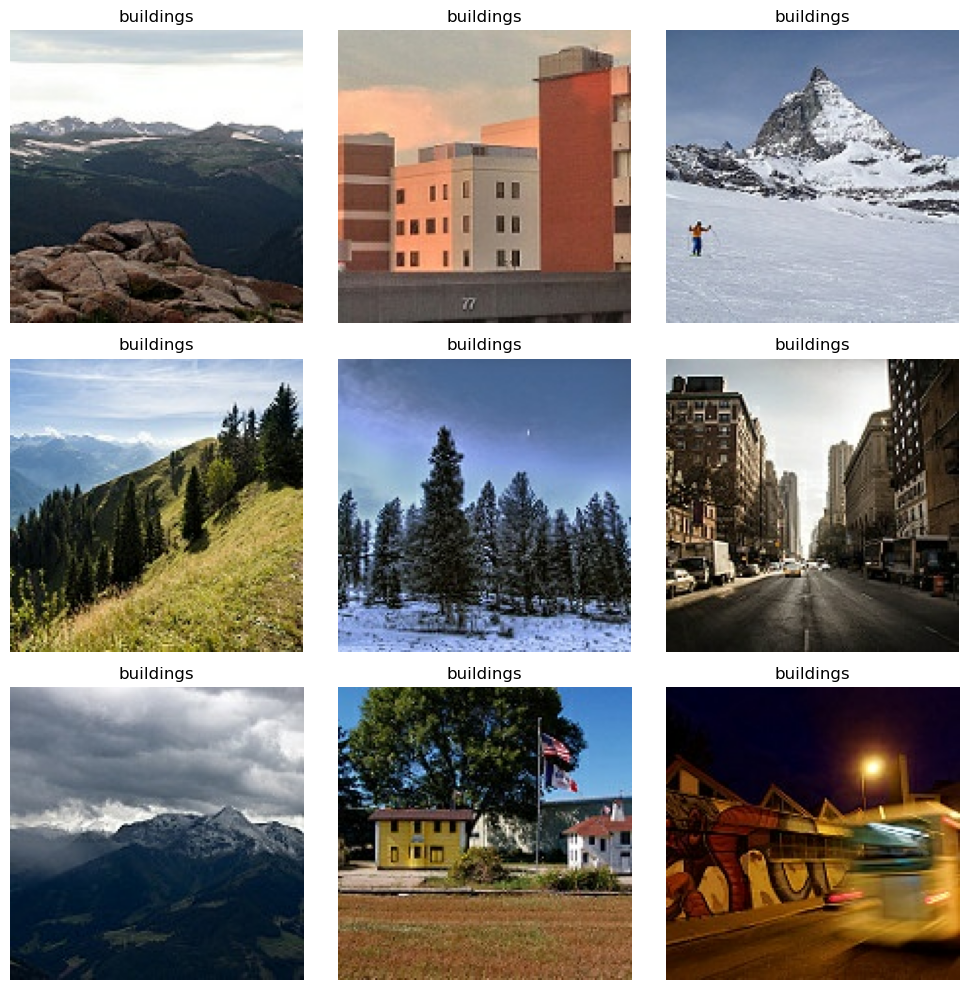

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
axes = axes.flatten()
it = iter(train_ds)

for i in range(9):    
    elem = it.get_next()
    image = elem[0].numpy()[0].astype("uint8")
    label = np.argmax(elem[1].numpy())
    
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(classes[label])
    ax.axis('off')
plt.tight_layout()
plt.show()

2023-01-20 17:08:56.418500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 8658 of 17034
2023-01-20 17:09:06.420300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 16574 of 17034
2023-01-20 17:09:08.104926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-01-20 17:09:08.105219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1022
2023-01-20 17:09:08.105318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 1022
2023-01-20 17:09:08.108133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


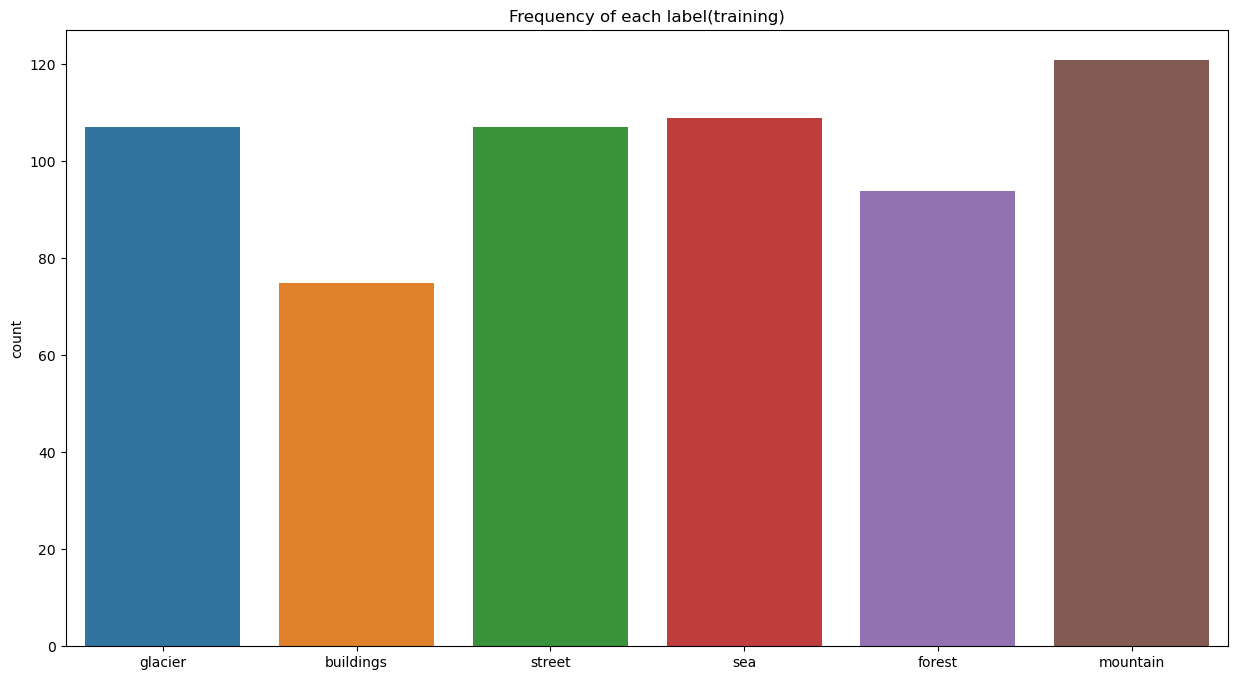

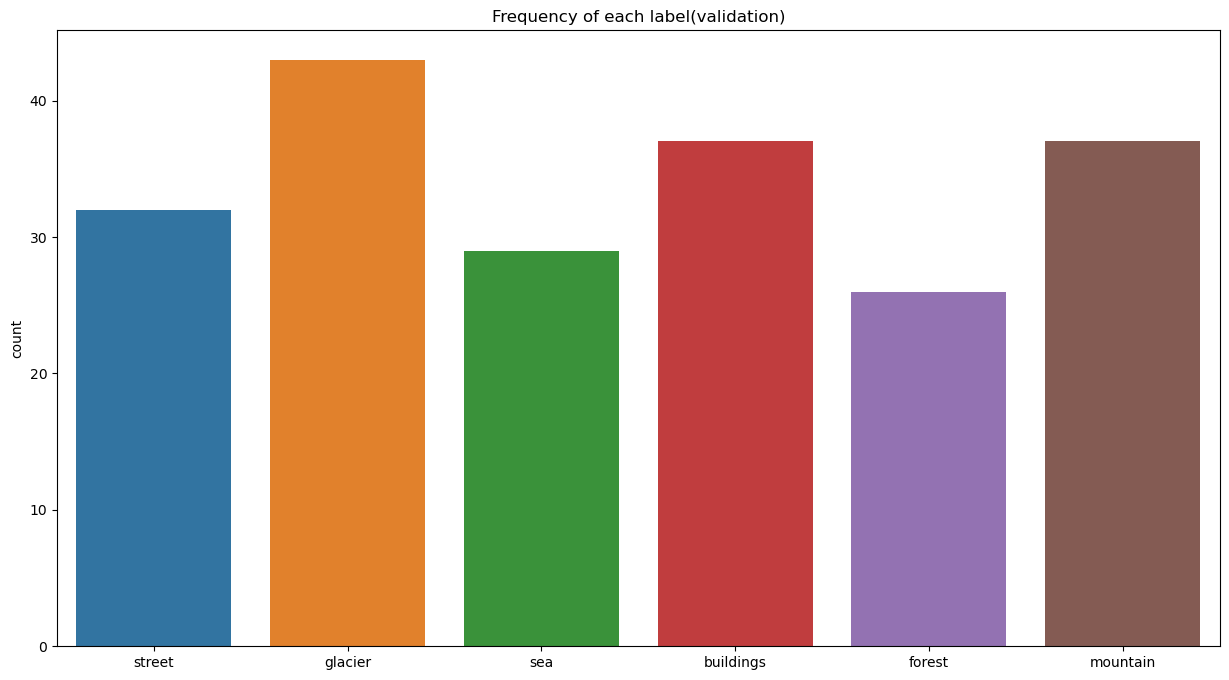

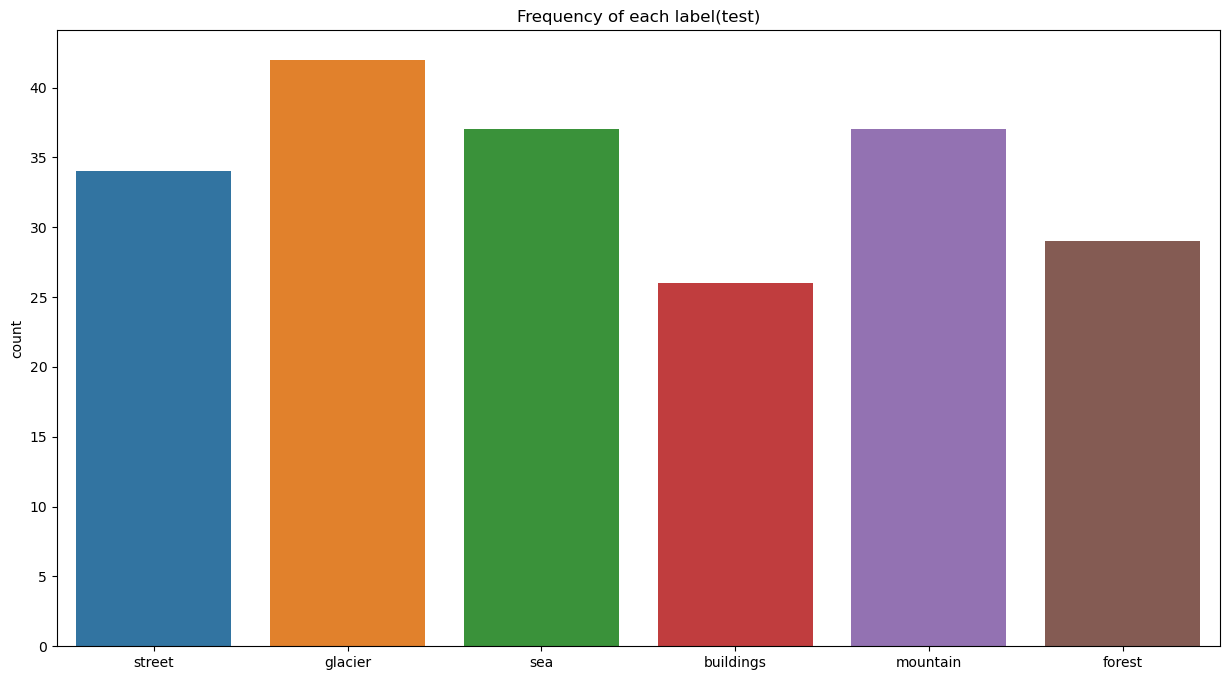

In [11]:
# get frequency for each subset
show_bar_chart(train_ds, "training")
show_bar_chart(val_ds, "validation")
show_bar_chart(test_ds, "test")

### Get input image size

In [12]:
# get images size
# It is too heavy to keep repeating this instruction
input_size = get_img_size(train_ds)

In [13]:
# get batch_sizes
batch_sizes = [64, 128, 256]

In [14]:
# number of epochs
epochs = 25

## Model number 01

In [15]:
def basic_model01(input_size):
    X_input = Input(input_size, name="input")
    
    # Rescale image to range [0,1]
    X = Rescaling(1.0/255)(X_input)
    
    # Conv01
    X = Conv2D(32, (3, 3), activation='relu', name = 'conv01_32-3')(X)
    X = MaxPooling2D((2, 2), name='max_pool01')(X)
    
    # Conv02
    X = Conv2D(64, (3, 3), activation='relu', name = 'conv02_64-3')(X)
    X = MaxPooling2D((2, 2), name='max_pool02')(X)
    
    # Conv03
    X = Conv2D(128, (3, 3), activation='relu', name = 'conv03_128-3')(X)
    X = MaxPooling2D((2, 2), name='max_pool03')(X)
    
    #Flatten
    X = Flatten()(X)
    
    #FC01
    X = Dense(64, activation='relu', name = 'FC01_64_relu')(X)
    
    #Output
    X = Dense(len(classes), activation="softmax", name = 'softmax_6')(X)
    
    #create
    return Model(inputs = X_input, outputs = X)

## Model 02

In [16]:
def basic_model02(input_size):
    X_input = Input(input_size)
    
    # Rescale image to range [0,1]
    X = Rescaling(1.0/255)(X_input)
    
    # Conv01
    X = Conv2D(32, (3, 3), activation='relu', name = 'conv01')(X)
    X = MaxPooling2D((2, 2), name='max_pool01')(X)
    
    # Conv02
    X = Conv2D(64, (3, 3), activation='relu', name = 'conv02')(X)
    X = MaxPooling2D((2, 2), name='max_pool02')(X)
    
    # Conv03
    X = Conv2D(128, (3, 3), activation='relu', name = 'conv03')(X)
    X = MaxPooling2D((2, 2), name='max_pool03')(X)

    # Conv04
    X = Conv2D(256, (3, 3), activation='relu', name = 'conv04')(X)
    X = MaxPooling2D((2, 2), name='max_pool04')(X)
    
    #Flatten
    X = Flatten()(X)
    
    #FC01
    X = Dense(64, activation='relu', name = 'FC01')(X)
    
    X = Dropout(0.3)(X)

    #Output
    X = Dense(len(classes), activation="softmax", name = 'output')(X)
    
    #create
    return Model(inputs = X_input, outputs = X)

## Model 03

In [17]:
def basic_model03(input_size):
    X_input = Input(input_size)
    
    # Rescale image to range [0,1]
    X = Rescaling(1.0/255)(X_input)
    
    # block 01
    X = Conv2D(32, (3, 3), activation='relu', name = 'b1_conv1')(X)
    X = Conv2D(32, (3, 3), activation='relu', name = 'b1_conv2')(X)
    X = MaxPooling2D((2, 2), name='max_pool01')(X)
    
    # Conv02
    X = Conv2D(64, (3, 3), activation='relu', name = 'b2_conv1')(X)
    X = Conv2D(64, (3, 3), activation='relu', name = 'b2_conv2')(X)
    X = MaxPooling2D((2, 2), name='max_pool02')(X)
    
    # Conv03
    X = Conv2D(128, (3, 3), activation='relu', name = 'b3_conv1')(X)
    X = Conv2D(128, (3, 3), activation='relu', name = 'b3_conv2')(X)
    X = MaxPooling2D((2, 2), name='max_pool03')(X)

    # Conv04
    X = Conv2D(256, (3, 3), activation='relu', name = 'b4_conv1')(X)
    X = Conv2D(256, (3, 3), activation='relu', name = 'b4_conv2')(X)
    X = MaxPooling2D((2, 2), name='max_pool04')(X)
    
    #Flatten
    X = Flatten()(X)
    
    #FC01
    X = Dense(128, activation='relu', name = 'FC01')(X)
    
    #FC02
    X = Dense(128, activation='relu', name = 'FC02')(X)
    
    X = Dropout(0.5)(X)

    #Output
    X = Dense(len(classes), activation="softmax", name = 'output')(X)
    
    #create
    return Model(inputs = X_input, outputs = X)

## Model 04

In [18]:
def basic_model04(input_size):
    X_input = Input(input_size)
    
    # Rescale image to range [0,1]
    X = Rescaling(1.0/255)(X_input)
    
    # block 01
    X = Conv2D(32, (3, 3), name = 'b1_conv1')(X)
    X = BatchNormalization(axis = 3, name = 'b1_bn1')(X)
    X = Activation('relu')(X)
    X = Conv2D(32, (3, 3), name = 'b1_conv2')(X)
    X = BatchNormalization(axis = 3, name = 'b1_bn2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool01')(X)
    
    # Conv02
    X = Conv2D(64, (3, 3), name = 'b2_conv1')(X)
    X = BatchNormalization(axis = 3, name = 'b2_bn1')(X)
    X = Activation('relu')(X)
    X = Conv2D(64, (3, 3), name = 'b2_conv2')(X)
    X = BatchNormalization(axis = 3, name = 'b2_bn2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool02')(X)
    
    # Conv03
    X = Conv2D(128, (3, 3), name = 'b3_conv1')(X)
    X = BatchNormalization(axis = 3, name = 'b3_bn1')(X)
    X = Activation('relu')(X)
    X = Conv2D(128, (3, 3), name = 'b3_conv2')(X)
    X = BatchNormalization(axis = 3, name = 'b3_bn2')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool03')(X)

    # Conv04
    X = Conv2D(256, (3, 3), name = 'b4_conv1')(X)
    X = BatchNormalization(axis = 3, name = 'b4_bn1')(X)
    X = Activation('relu')(X)
    X = Conv2D(256, (3, 3), name = 'b4_conv2')(X)
    X = BatchNormalization(axis = 3, name = 'b4_bn1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool04')(X)
    
    #Flatten
    X = Flatten()(X)
    
    #FC01
    X = Dense(128, activation='relu', name = 'FC01')(X)
    X = Dropout(0.5)(X)
    
    #FC02
    X = Dense(128, activation='relu', name = 'FC02')(X)
    X = Dropout(0.5)(X)

    #Output
    X = Dense(len(classes), activation="softmax", name = 'output')(X)
    
    #create
    return Model(inputs = X_input, outputs = X)

## State-of-the-art Model - VGG16


In [19]:
def sota_model(input_size):
    
    vgg16 = VGG16(
        input_shape=input_size,
        weights='imagenet',
        include_top=False,
    )
    vgg16.trainable = False
    
    #Flatten
    X = Flatten()(vgg16.output)

    #Output
    X = Dense(len(classes), activation="softmax", name = 'output')(X)
    
    #create
    return Model(inputs = vgg16.input, outputs = X)

## Final model

In [20]:
def final_model(input_size):
    X_input = Input(input_size)
    
    X = Rescaling(1.0/255)(X_input)

    # Conv01
    X = Conv2D(32, (3, 3), strides=(1,1), padding='same' )(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((2, 2))(X)
    
    # Conv02
    X = Conv2D(32, (3, 3), strides=(1,1), padding='same' )(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((2, 2))(X)
    
    # Conv03
    X = Conv2D(32, (3, 3), strides=(1,1), padding='same' )(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((2, 2))(X)
    
    # Conv04
    X = Conv2D(32, (3, 3), strides=(1,1), padding='same' )(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((2, 2))(X)
    
    #Flatten
    X = Flatten()(X)
    
    X = Dense(128, activation='relu')(X)

    X = Dropout(0.2)(X)
    
    #Output
    X = Dense(len(classes), activation="softmax")(X)
    
    #create
    return Model(inputs = X_input, outputs = X)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                           

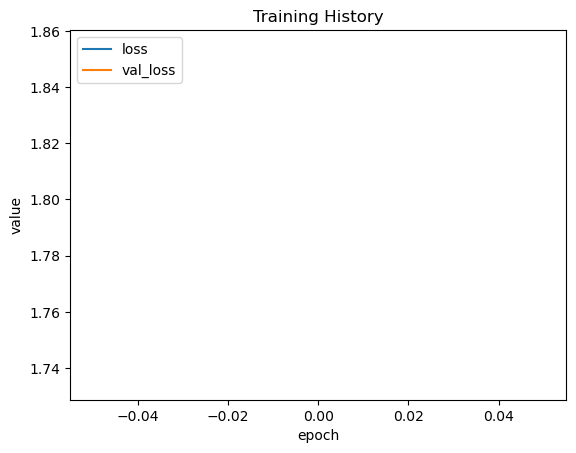

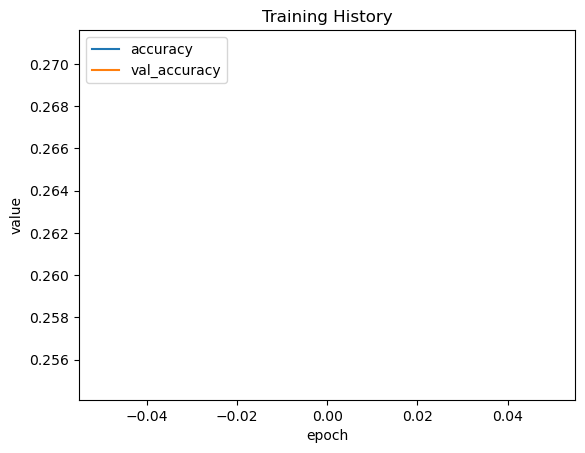

205/205 [==============================] - 8s 16ms/step


/home/renan/anaconda3/envs/faa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/renan/anaconda3/envs/faa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/renan/anaconda3/envs/faa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


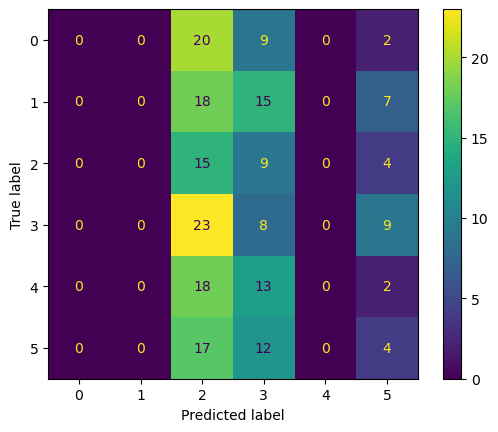

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00        40
           2       0.14      0.54      0.22        28
           3       0.12      0.20      0.15        40
           4       0.00      0.00      0.00        33
           5       0.14      0.12      0.13        33

    accuracy                           0.13       205
   macro avg       0.07      0.14      0.08       205
weighted avg       0.07      0.13      0.08       205



In [21]:
loss = "sparse_categorical_crossentropy"
optimizer = "adam"
batch_size = 256

final_model = final_model(input_size)
compile_model(final_model, optimizer, loss)
history = final_model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=epochs,
)
evaluate(final_model, history, test_ds)